In [1]:
import numpy as np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pickle

from helper.read_GEOSldas import read_tilecoord, read_obs_param
from helper.util import make_folder, array2grid
from helper.plot import plotMap
from helper.smapeasev2 import smapeasev2_ind2latlon

import warnings; warnings.filterwarnings("ignore")
import sys 
import io

#sys.stdout = io.TextIOWrapper(open(sys.stdout.fileno(), 'wb', 0), write_through=True)
#sys.stderr = io.TextIOWrapper(open(sys.stderr.fileno(), 'wb', 0), write_through=True)

In [2]:
expdir = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/'
expid = 'LS_OLv8_M36'
domain = 'SMAP_EASEv2_M36_GLOBAL'

start_time = datetime(2020,1,1)
end_time = datetime(2021,1,1)

In [3]:
# Define a minimum threshold for the temporal data points to ensure statistical reliability
# of the computed metrics. 
Nmin = 20

# Base directory for storing monthly files
# This can be the same as the experiment directory (expdir) or a different location
out_path_mo = expdir+expid+'/output/'+domain+'/ana/ens_avg/'

# Directory for diagnostic plots
out_path = expdir+expid+'/output/'+domain+'/figures/'
make_folder(out_path)

# Variable list for computing sum and sum of squared
var_list = ['obs_obs', 'obs_obsvar','obs_fcst','obs_fcstvar','obs_ana','obs_anavar']

In [4]:
# Read tilecoord and obsparam for tile and obs species information
ftc = os.path.join(expdir, expid, 'output', domain, 'rc_out', f'{expid}.ldas_tilecoord.bin')
tc = read_tilecoord(ftc)
n_tile = tc['N_tile']

# Construct the file path dynamically using start_time
fop = os.path.join(
    expdir, expid, 'output', domain, 'rc_out',
    'Y' + start_time.strftime('%Y'),
    'M' + start_time.strftime('%m'),
    f"{expid}.ldas_obsparam.{start_time.strftime('%Y%m%d')}_0000z.txt"
)
obs_param = read_obs_param(fop)
n_spec = len(obs_param)

reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/rc_out/LS_OLv8_M36.ldas_tilecoord.bin
done reading file
Reading /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/rc_out/Y2020/M01/LS_OLv8_M36.ldas_obsparam.20200101_0000z.txt
Done reading obs_param for 13 species


In [5]:
species_groups = {
    "SMOS": [0, 1, 2, 3],
    "SMAP": [4, 5, 6, 7],
    "ASCAT": [8, 9, 10],
    "MODIS": [11, 12]
}

In [6]:
# Initialize statistical metrics 
data_sum = {}
data2_sum = {}
N_data = np.zeros((n_tile, n_spec))
oxf_sum = np.zeros((n_tile, n_spec))
oxa_sum = np.zeros((n_tile, n_spec))
fxa_sum = np.zeros((n_tile, n_spec))

for var in var_list:
    data_sum[var] = np.zeros((n_tile, n_spec))
    data2_sum[var] = np.zeros((n_tile, n_spec))

# Initialize storage for monthly time series data
N_data_group_all_months = {group: [] for group in species_groups}
OmF_mean_all_months = {group: [] for group in species_groups}
OmF_stdv_all_months = {group: [] for group in species_groups}
monthly_timestamps = []  # To store the timestamps for each month


In [7]:

# Time loop: processing data at monthly time step
date_time = start_time
while date_time < end_time:
    # File to store monthly statistics    
    fout_path = out_path_mo + '/Y' + date_time.strftime('%Y') + '/M' + date_time.strftime('%m') + '/'
    make_folder(fout_path)
    
    fout = fout_path + expid + '.ens_avg.ldas_ObsFcstAna.' + date_time.strftime('%Y%m') + '_stats_CROSSMASKED.nc4'

    # Read monthly data if file exists
    if os.path.isfile(fout):
        print('Reading sums from monthly file: ' + fout)
        with Dataset(fout, 'r') as nc:
            mN_data = nc.variables['N_data'][:]  # Shape: (tiles, species)
            moxf_sum = nc.variables['obsxfcst_sum'][:]  # Shape: (tiles, species)
            moxa_sum = nc.variables['obsxana_sum'][:]
            mfxa_sum = nc.variables['fcstxana_sum'][:]            
            mdata_sum = {var: nc.variables[var + '_sum'][:] for var in var_list}
            mdata2_sum = {var: nc.variables[var + '2_sum'][:] for var in var_list}
    else:
        print('Cannot find monthly file: ' + fout)
        date_time += relativedelta(months=1)
        continue

    # Compute metrics for each species group
    for group, indices in species_groups.items():
        # Sum across tiles for the species in this group
        N_data_group = np.sum(mN_data[:, indices], axis=1)  # Total count for the group
        OmF_sum_group = np.sum(moxf_sum[:, indices], axis=1)  # Total OmF sum for the group

        # Convert N_data_group to float to allow NaN values
        N_data_group = N_data_group.astype(float)

        # Filter out invalid data
        N_data_group[N_data_group == 0] = np.nan

        # Compute group-level means and variances
        data_mean = {var: np.sum(mdata_sum[var][:, indices], axis=1) / N_data_group for var in var_list}
        data2_mean = {var: np.sum(mdata2_sum[var][:, indices], axis=1) / N_data_group for var in var_list}
        data_var = {var: data2_mean[var] - data_mean[var]**2 for var in var_list}

        # Compute OmF_mean and OmF_stdv
        OmF_mean = data_mean['obs_obs'] - data_mean['obs_fcst']
        OmF_stdv = np.sqrt(
            data_var['obs_obs'] + data_var['obs_fcst'] -
            2 * (OmF_sum_group / N_data_group - data_mean['obs_obs'] * data_mean['obs_fcst'])
        )

        # Ensure arrays are writable
        OmF_mean = np.copy(OmF_mean)
        OmF_stdv = np.copy(OmF_stdv)

        # Aggregate results to single values
        N_data_group_total = np.nansum(N_data_group)  # Total N_data for the group
        OmF_mean_avg = np.nanmean(OmF_mean)  # Mean OmF for the group
        OmF_stdv_avg = np.nanmean(OmF_stdv)  # Stdv OmF for the group

        # Store the results for the current month
        N_data_group_all_months[group].append(N_data_group_total)
        OmF_mean_all_months[group].append(OmF_mean_avg)
        OmF_stdv_all_months[group].append(OmF_stdv_avg)

    # Store the current timestamp for the month
    monthly_timestamps.append(date_time)

    # Aggregate monthly data
    N_data += mN_data
    oxf_sum += moxf_sum
    oxa_sum += moxa_sum
    fxa_sum += mfxa_sum
   
    for var in var_list:
        data_sum[var] += mdata_sum[var] 
        data2_sum[var] += mdata2_sum[var]      

    # Increment to the next month
    date_time += relativedelta(months=1)


Reading sums from monthly file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M01/LS_OLv8_M36.ens_avg.ldas_ObsFcstAna.202001_stats_CROSSMASKED.nc4
Reading sums from monthly file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M02/LS_OLv8_M36.ens_avg.ldas_ObsFcstAna.202002_stats_CROSSMASKED.nc4
Reading sums from monthly file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M03/LS_OLv8_M36.ens_avg.ldas_ObsFcstAna.202003_stats_CROSSMASKED.nc4
Reading sums from monthly file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M04/LS_OLv8_M36.ens_avg.ldas_ObsFcstAna.202004_stats_CROSSMASKED.nc4
Reading sums from monthly file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_swe

In [8]:

# Save the lists of monthly data to a file
with open(out_path + f'monthly_OmF_data_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'wb') as f:
    pickle.dump({
        'N_data_group_all_months': N_data_group_all_months,
        'OmF_mean_all_months': OmF_mean_all_months,
        'OmF_stdv_all_months': OmF_stdv_all_months,
        'monthly_timestamps': monthly_timestamps
    }, f)


In [9]:
# Compute the final statistics
# This section calculate the final statistical metrics based on the accumulated data.
data_mean ={}
data2_mean = {}
data_var = {}

# First, compute the metrics of individual variables  
for var in var_list:
    data_sum[var][N_data == 0] = np.nan
    data2_sum[var][N_data == 0] = np.nan
    
    data_mean[var]  = data_sum[var] / N_data
    data2_mean[var] = data2_sum[var] /N_data
    # var(x) = E[x2] - (E[x])^2
    data_var[var] = data2_mean[var] - data_mean[var]**2
    
oxf_sum[N_data == 0] = np.nan
oxa_sum[N_data == 0] = np.nan
fxa_sum[N_data == 0] = np.nan
# E[xy]
oxf_mean = oxf_sum / N_data
oxa_mean = oxa_sum / N_data
fxa_mean = fxa_sum / N_data

# Then computer metrics of O-F, O-A, etc. based on above computed 
# mean(x-y) = E[x] - E[y]   
OmF_mean = data_mean['obs_obs'] - data_mean['obs_fcst']
OmA_mean = data_mean['obs_obs'] - data_mean['obs_ana']
# var(x-y) = var(x) + var(y) - 2cov(x,y)
# cov(x,y) = E[xy] - E[x]E[y]
OmF_stdv  = np.sqrt(data_var['obs_obs'] + data_var['obs_fcst'] - \
                       2 * (oxf_mean - data_mean['obs_obs']*data_mean['obs_fcst']))
                    
OmA_stdv  = np.sqrt(data_var['obs_obs'] + data_var['obs_ana'] - \
                       2 * (oxa_mean - data_mean['obs_obs']*data_mean['obs_ana']))

OmF_norm_mean = OmF_mean / np.sqrt(data_mean['obs_obsvar'] + data_mean['obs_fcstvar']) 
OmF_norm_stdv = np.sqrt(OmF_stdv**2 / (data_mean['obs_obsvar'] + data_mean['obs_fcstvar']) )
    
# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[N_data < Nmin] = np.nan
OmF_stdv[N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[N_data < Nmin] = np.nan
OmA_stdv[N_data < Nmin] = np.nan


In [10]:
group_metrics = {}

for group, species_indices in species_groups.items():
    group_metrics[group] = {}
    group_N_data = np.nansum(N_data[:, species_indices], axis=1)
    
    group_metrics[group]['OmF_mean'] = np.nansum(OmF_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['OmF_stdv'] = np.nansum(OmF_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['OmF_norm_mean'] = np.nansum(OmF_norm_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['OmF_norm_stdv'] = np.nansum(OmF_norm_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['OmA_mean'] = np.nansum(OmA_mean[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['OmA_stdv'] = np.nansum(OmA_stdv[:, species_indices] * N_data[:, species_indices], axis=1) / group_N_data
    group_metrics[group]['Nobs_data'] = group_N_data

In [11]:
import pickle
import os

# Debugging: Check out_path
print("out_path:", out_path)

# Ensure the directory exists
os.makedirs(out_path, exist_ok=True)

# Debugging: Check group_metrics before saving
print("group_metrics:", group_metrics)

# Save the group_metrics dictionary to a file
with open(out_path + f'group_metrics_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'wb') as f:
    pickle.dump(group_metrics, f)

# Debugging: Check if the file was saved
print("File exists:", os.path.exists(out_path + 'group_metrics.pkl'))

# Load the group_metrics dictionary from the file
with open(out_path + f'group_metrics_{expid}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.pkl', 'rb') as f:
    loaded_group_metrics = pickle.load(f)

# Debugging: Check the loaded dictionary
print("loaded_group_metrics:", loaded_group_metrics)
print("loaded_group_metrics keys:", loaded_group_metrics.keys())

out_path: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/
group_metrics: {'SMOS': {'OmF_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_norm_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_norm_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'OmA_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmA_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'Nobs_data': array([0., 0., 0., ..., 0., 0., 0.])}, 'SMAP': {'OmF_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_norm_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmF_norm_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'OmA_mean': array([nan, nan, nan, ..., nan, nan, nan]), 'OmA_stdv': array([nan, nan, nan, ..., nan, nan, nan]), 'Nobs_data': array([0., 0., 0., ..., 0., 0., 0.])}, 'ASCAT': {'OmF_mean': array([nan, nan, nan, 

In [12]:
import pickle

# Plotting
expdir = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/'
expid = 'LS_DAv8_M36'
domain = 'SMAP_EASEv2_M36_GLOBAL'
outpath = "./"

start_time = datetime(2000,6,1)
end_time = datetime(2024,4,1)

# Load the group_metrics dictionary from the file
with open('group_metrics.pkl', 'rb') as f:
   loaded_group_metrics = pickle.load(f)

# Load the group_metrics dictionary from the file
#with open(out_path + 'group_metrics.pkl', 'rb') as f:
#    loaded_group_metrics = pickle.load(f)    

print("loaded_group_metrics keys:", loaded_group_metrics.keys())



loaded_group_metrics keys: dict_keys(['SMOS', 'SMAP', 'ASCAT', 'MODIS'])


SMOS N_data (in millions): [0.666925, 0.644878, 0.700858, 0.721798, 0.823874, 0.961359, 1.10454, 1.090579, 0.837371, 0.738658, 0.680714, 0.668905]
SMAP N_data (in millions): [2.449927, 2.334883, 2.690757, 2.938788, 3.586296, 3.963508, 4.370554, 4.423287, 3.692411, 3.100332, 2.584334, 2.37656]
ASCAT N_data (in millions): [1.82884, 1.790477, 2.233529, 2.556342, 3.258567, 3.449106, 3.627241, 3.448997, 3.058993, 2.619496, 2.186874, 1.925383]
MODIS N_data (in millions): [4.342513, 4.486242, 4.946708, 5.002846, 5.186013, 5.079984, 5.223889, 4.443985, 4.919135, 4.959856, 4.427631, 4.171052]


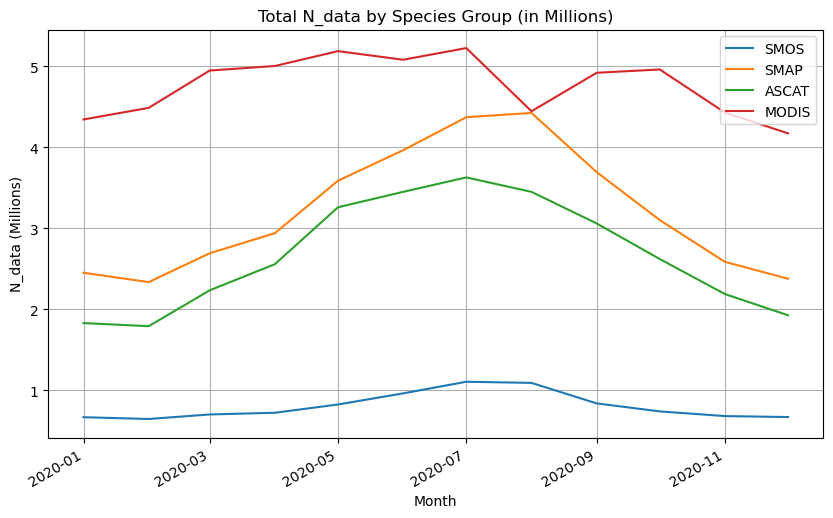

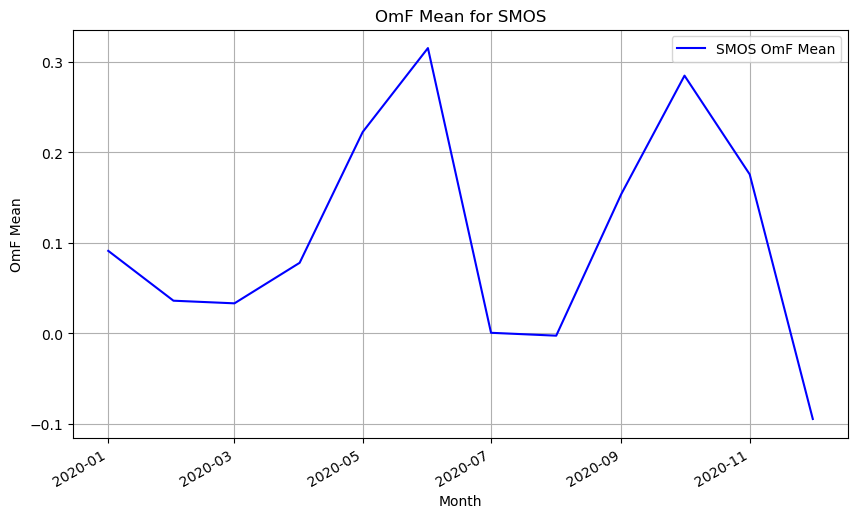

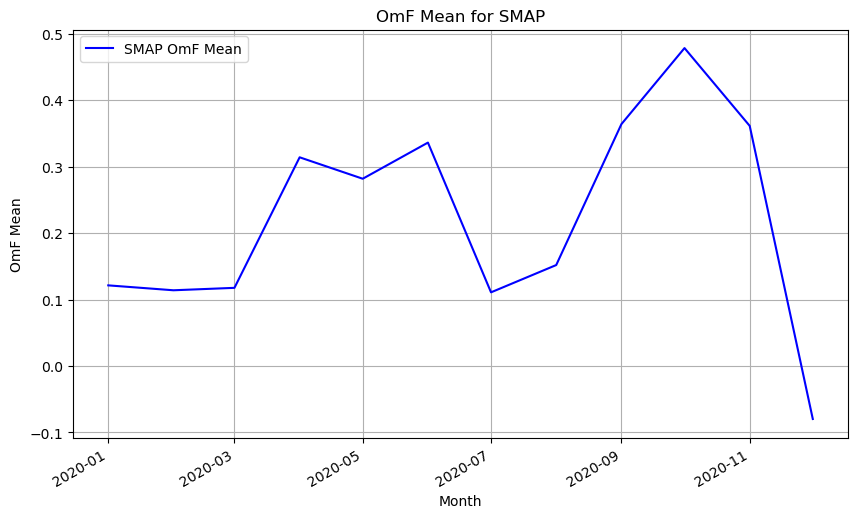

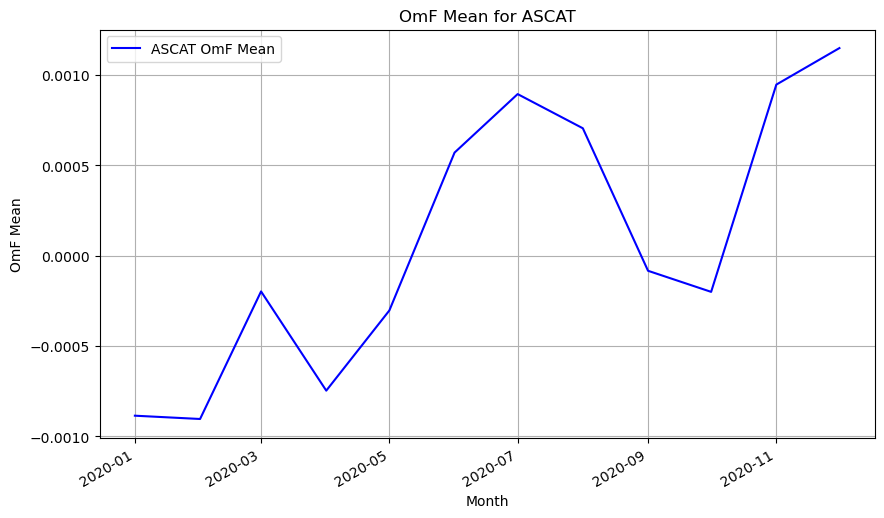

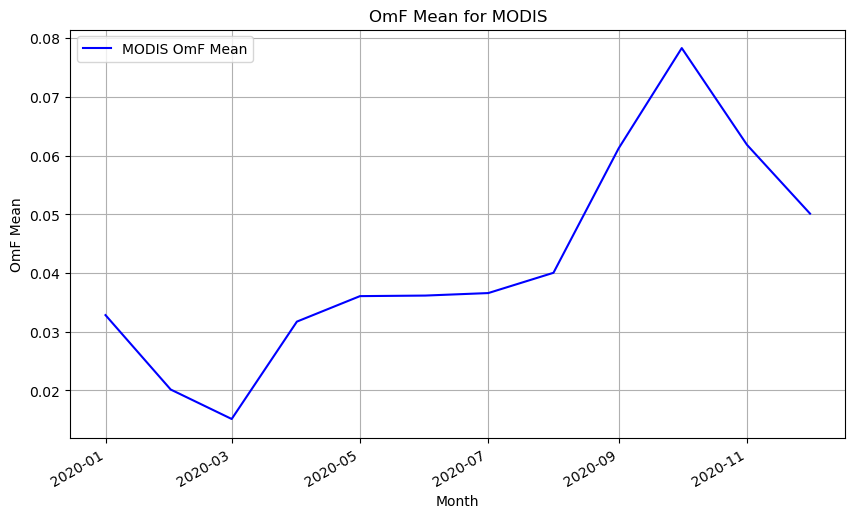

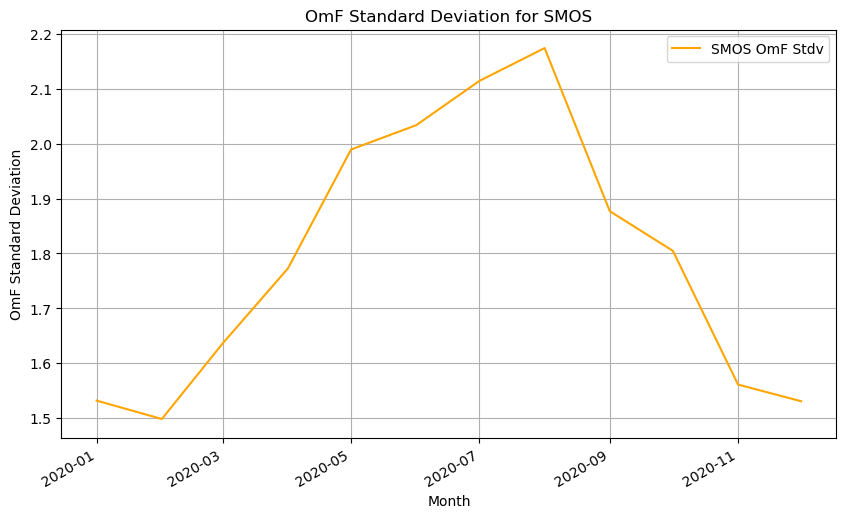

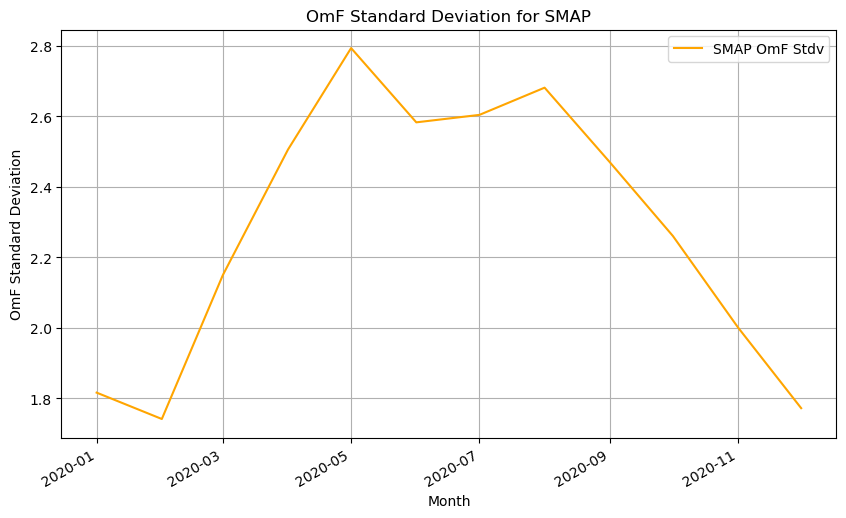

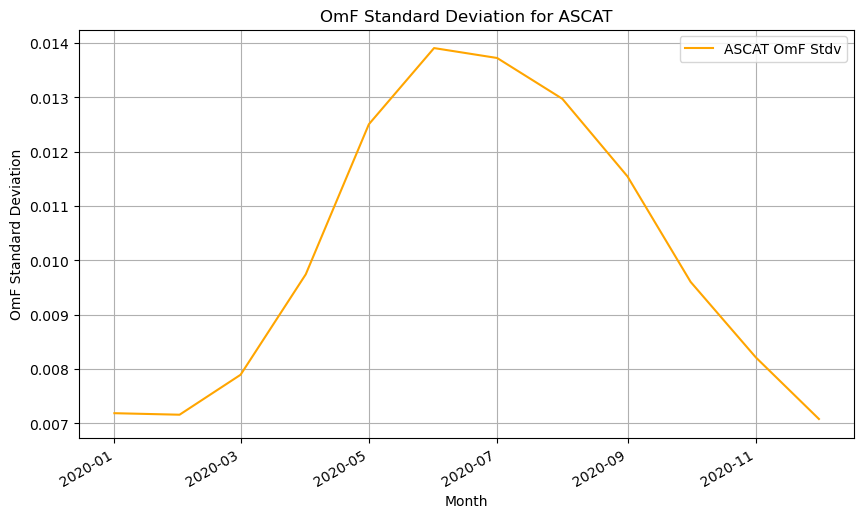

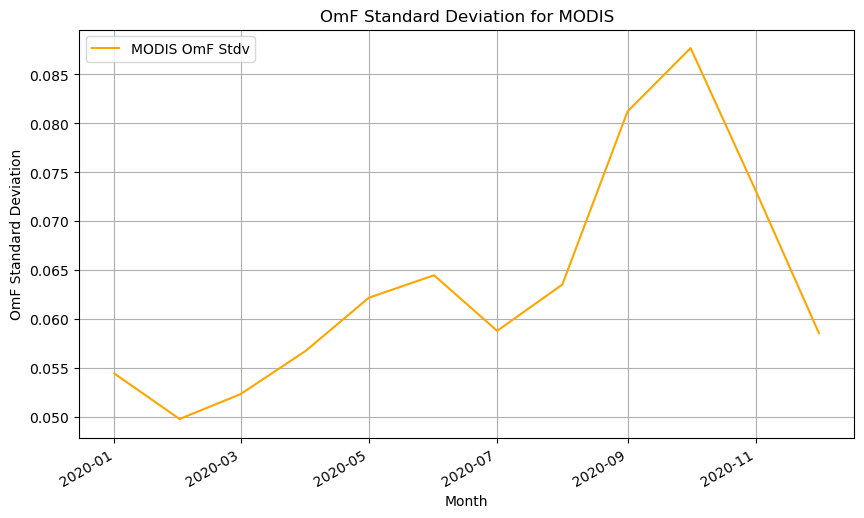

In [13]:
# Plot N_data_group for each species group
plt.figure(figsize=(10, 6))
for group, values in N_data_group_all_months.items():
    values_in_millions = [v / 1e6 for v in values]  # Convert to millions
    plt.plot(monthly_timestamps, values_in_millions, label=group)
    print(f"{group} N_data (in millions): {values_in_millions}")
plt.gcf().autofmt_xdate()
plt.xlabel('Month')
plt.ylabel('N_data (Millions)')
plt.title('Total N_data by Species Group (in Millions)')
plt.legend()
plt.grid()
plt.show()
plt.close()

# Plot OmF_mean for each species group
for group, values in OmF_mean_all_months.items():
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_timestamps, values, label=f'{group} OmF Mean', color='blue')
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Mean')
    plt.title(f'OmF Mean for {group}')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(out_path + f'OmF_Mean_{group}.png')  # Save the plot for each group
    plt.close()


# Plot OmF_stdv for each species group
for group, values in OmF_stdv_all_months.items():
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_timestamps, values, label=f'{group} OmF Stdv', color='orange')
    plt.gcf().autofmt_xdate()
    plt.xlabel('Month')
    plt.ylabel('OmF Standard Deviation')
    plt.title(f'OmF Standard Deviation for {group}')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(out_path + f'OmF_Stdv_{group}.png')  # Save the plot for each group
    plt.close()

Mean of grid_data: 85.63739973172963
Min of grid_data: 0.0
Max of grid_data: 325.0
Mean of grid_data: 0.11707712165775361
Min of grid_data: -15.132718172940343
Max of grid_data: 27.585093004950142
Mean of grid_data: 3.346976720079142
Min of grid_data: 0.0
Max of grid_data: 24.561033179689495
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: 0.5798921553840429


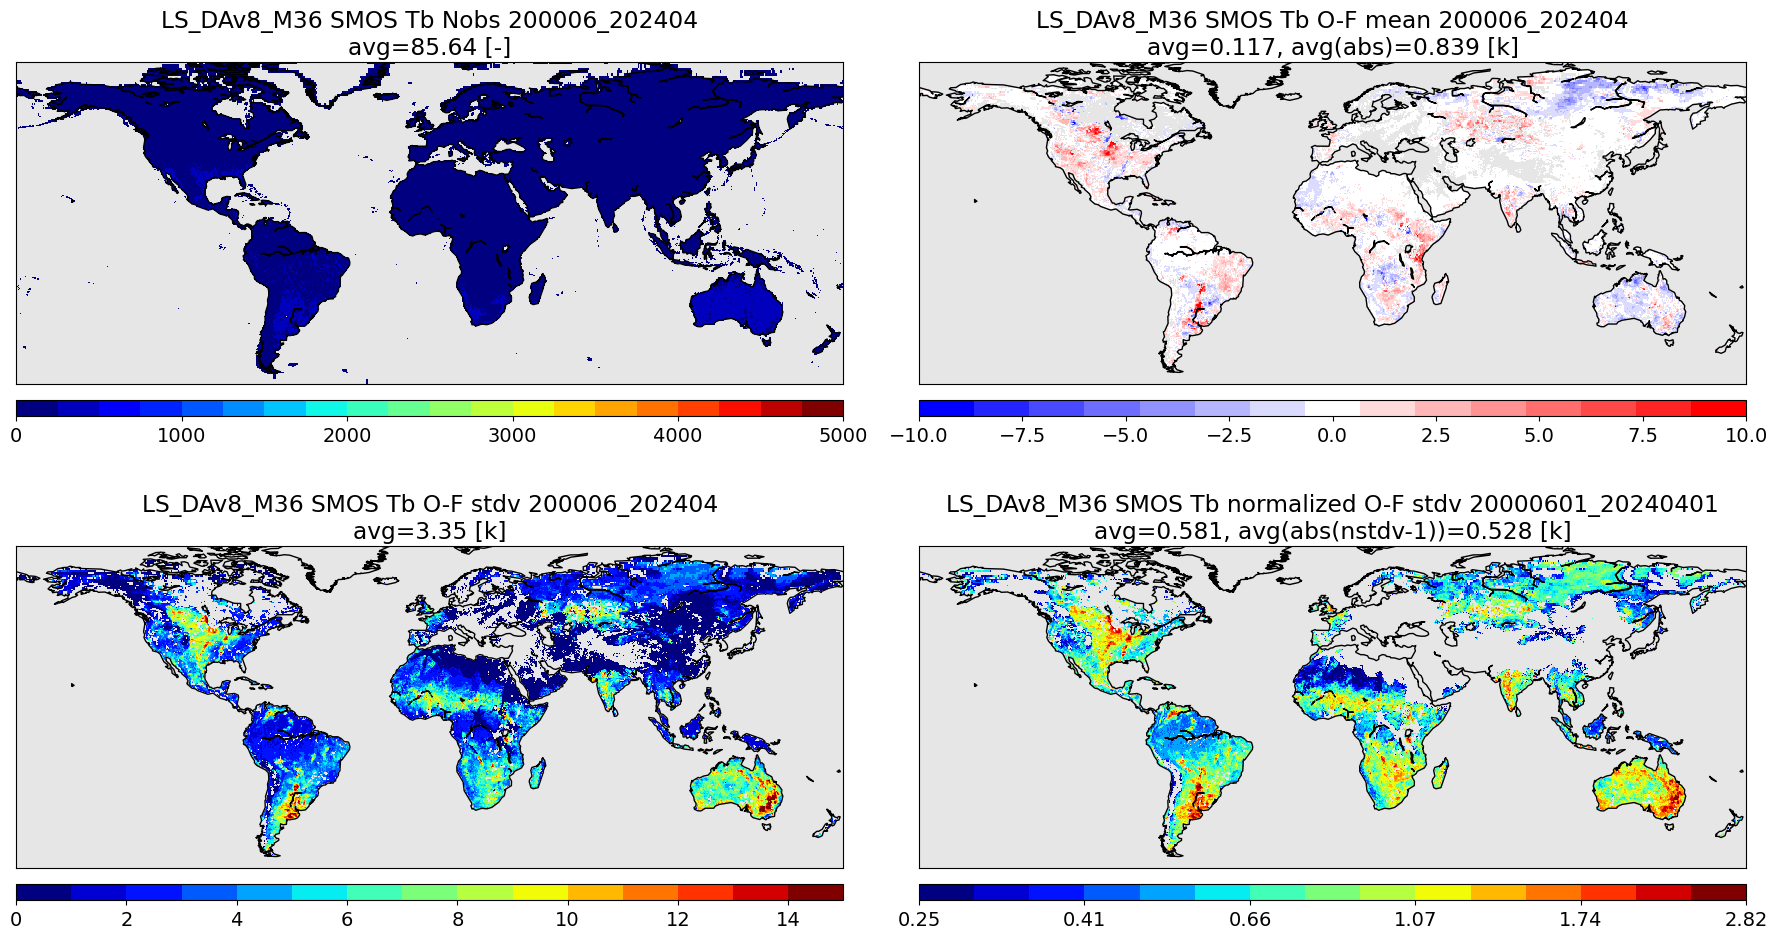

In [14]:
loaded_group_metrics = group_metrics


fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['SMOS']['Nobs_data']
OmF_mean = loaded_group_metrics['SMOS']['OmF_mean']
OmF_stdv = loaded_group_metrics['SMOS']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['SMOS']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['SMOS']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[k]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 5000] # np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SMOS Tb Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-10, 10]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SMOS Tb O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMOS Tb O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMOS Tb normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))
    
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 342.10367494869996
Min of grid_data: 0.0
Max of grid_data: 758.0
Mean of grid_data: 0.324035289661849
Min of grid_data: -28.987676303764978
Max of grid_data: 32.79248909825243
Mean of grid_data: 4.419606978022141
Min of grid_data: 0.0
Max of grid_data: 25.351738095253623
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: 0.6380816817086503


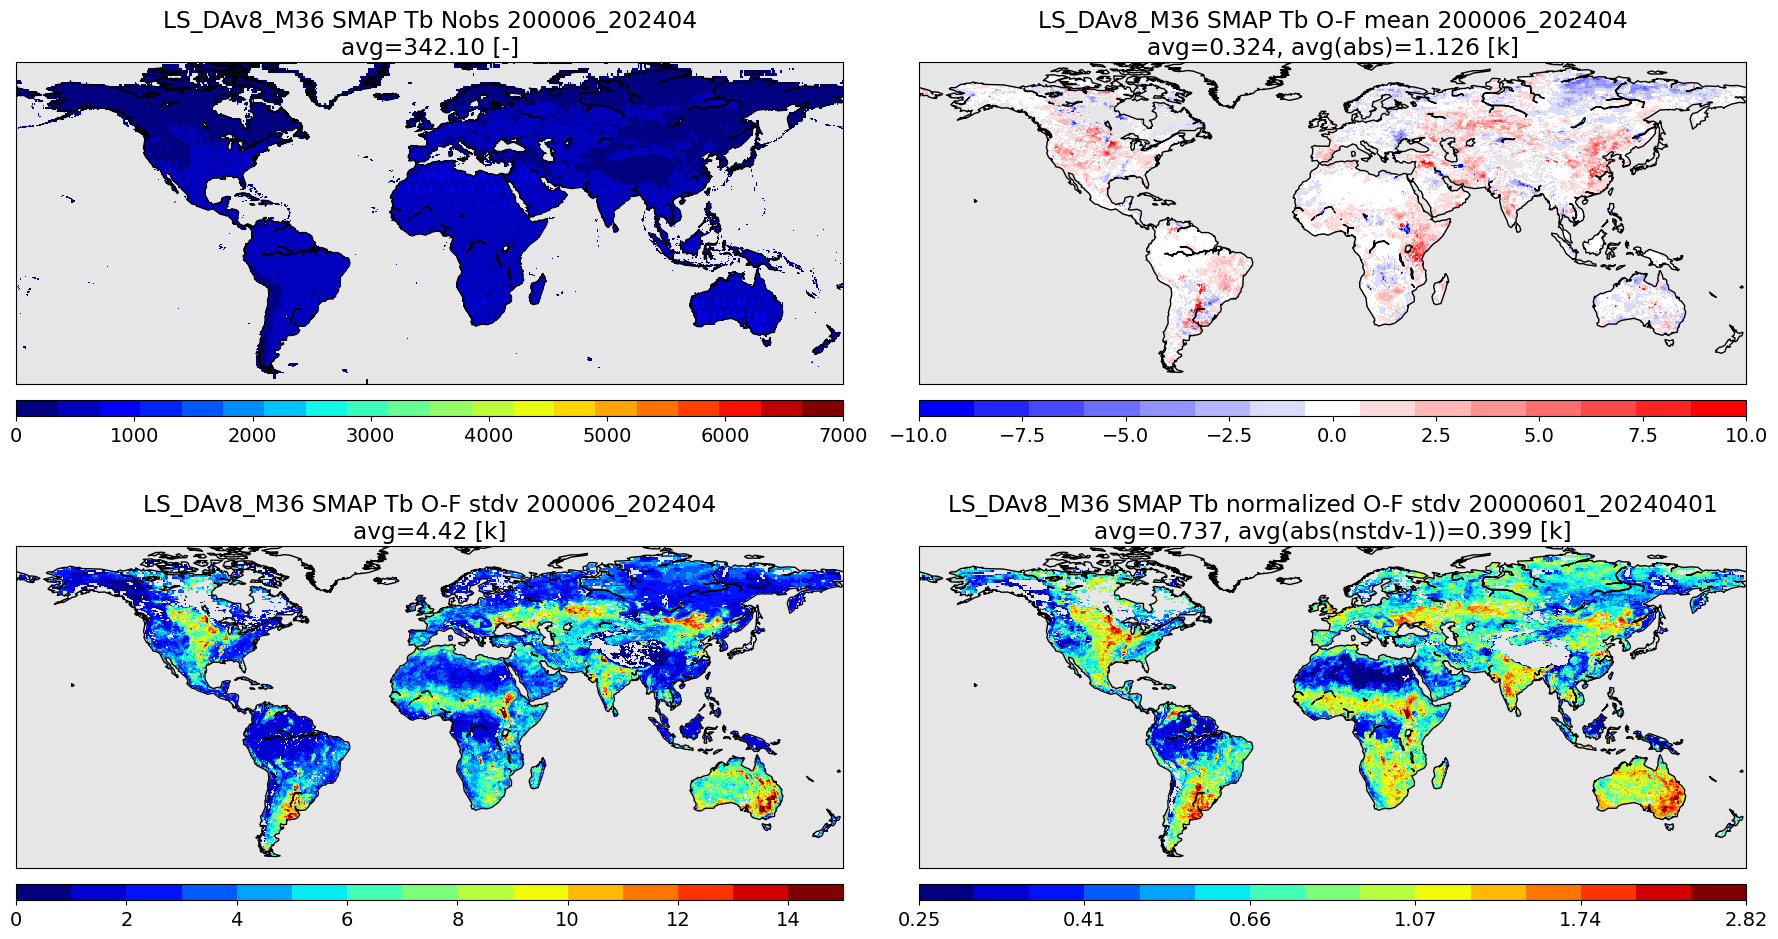

In [15]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['SMAP']['Nobs_data']
OmF_mean = loaded_group_metrics['SMAP']['OmF_mean']
OmF_stdv = loaded_group_metrics['SMAP']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['SMAP']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['SMAP']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[k]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 7000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SMAP Tb Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-10, 10]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SMAP Tb O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMAP Tb O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SMAP Tb normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))            
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 284.11648441455765
Min of grid_data: 0.0
Max of grid_data: 1373.0
Mean of grid_data: 0.0009402878423248603
Min of grid_data: -0.18910635409392706
Max of grid_data: 0.1409376957794515
Mean of grid_data: 0.023322502897447743
Min of grid_data: 0.0
Max of grid_data: 0.13137845906547058
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: 0.12532149503826326


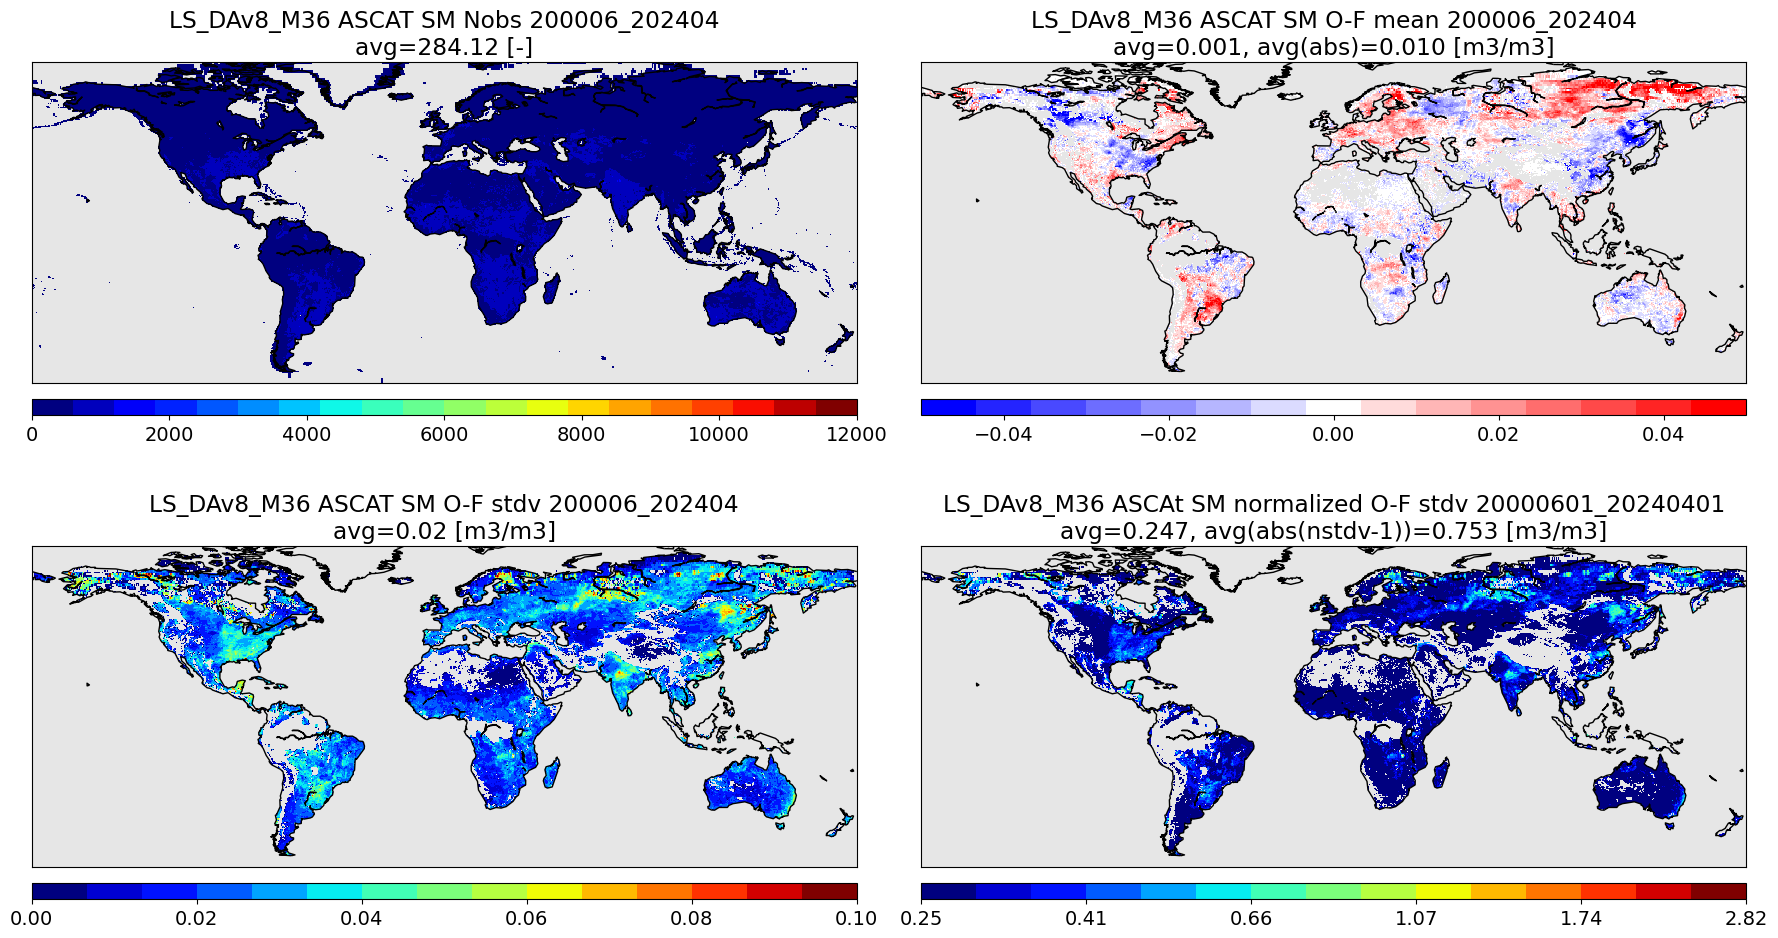

In [16]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['ASCAT']['Nobs_data']
OmF_mean = loaded_group_metrics['ASCAT']['OmF_mean']
OmF_stdv = loaded_group_metrics['ASCAT']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['ASCAT']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['ASCAT']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[m3/m3]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 12000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' ASCAT SM Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-0.05, 0.05]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' ASCAT SM O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 0.1]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' ASCAT SM O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' ASCAt SM normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))                
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

Mean of grid_data: 508.02460625549645
Min of grid_data: 0.0
Max of grid_data: 1364.0
Mean of grid_data: 0.04205499815386279
Min of grid_data: -0.2629378618032424
Max of grid_data: 0.9989823728935904
Mean of grid_data: 0.10879552955076614
Min of grid_data: 0.0
Max of grid_data: 0.5006358326968273
Mean of grid_data: -inf
Min of grid_data: -inf
Max of grid_data: -4.300434634268384


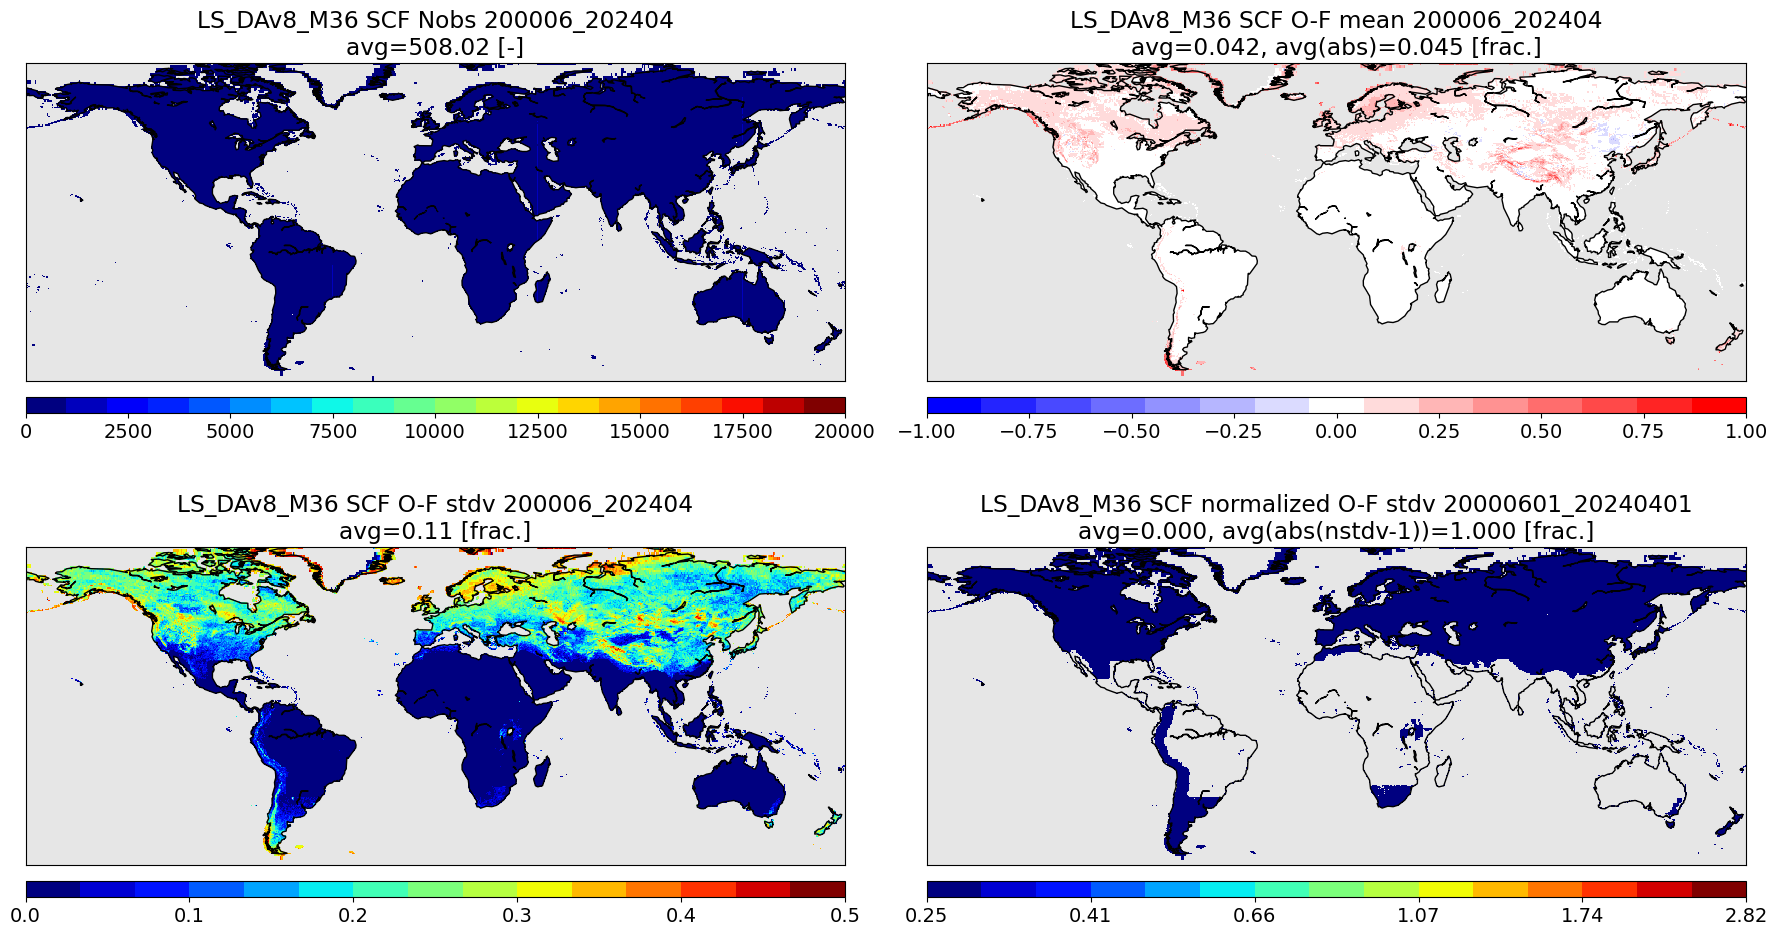

In [17]:
# Plotting
fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

Nobs_data = loaded_group_metrics['MODIS']['Nobs_data']
OmF_mean = loaded_group_metrics['MODIS']['OmF_mean']
OmF_stdv = loaded_group_metrics['MODIS']['OmF_stdv']
OmF_norm_mean = loaded_group_metrics['MODIS']['OmF_norm_mean']
OmF_norm_stdv = loaded_group_metrics['MODIS']['OmF_norm_stdv']

for i in np.arange(2):
    for j in np.arange(2):
        units = '[frac.]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, 20000] #np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' SCF Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-1, 1]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' SCF O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 0.5]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SCF O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' SCF normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            if i==0 and j==0:
                grid_data = np.sum(reshaped,axis=(1, 3)) 
            else:
                grid_data = np.nanmean(reshaped,axis=(1, 3))
                
            lat_M36, lon_M36 = smapeasev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)
            
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data-1.)))+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (np.nanmean(grid_data), np.nanmean(np.abs(grid_data)))+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (np.nanmean(grid_data)) +' '+units                

        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])    

        # Print the mean, min and max values of the grid data
        print('Mean of grid_data:', np.nanmean(grid_data))
        print('Min of grid_data:', np.nanmin(grid_data))
        print('Max of grid_data:', np.nanmax(grid_data))                  

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_OmF_'+expid+'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)